<div class="alert alert-success text-left">
<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 
<center> <h1>Trabajo práctico de laboratorio 2: Filtrado Digital</h1></center>
<h3> Teoría de circuitos 2 </h3>
<h3> 2do Cuatrimestre 2023 </h3>    
<h3> Facundo N. Iglesias </h3>    
</div>

<div class="alert alert-success text-left">

<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 

<center> <h1>INDICE</h1></center>
    
</div>

0. [LIBRERIAS](#lib)

1. [PARTE 1](#parte1)

    1.1[Diseño de filtro Anti-alias y filtro de Interpolación](#lpf)
    
    1.2[Requisitos de diseño](#consigna)

    1.3[Filtro A: FIR Pasa-bajos Equiripple](#filtroA)
    
    1.4[Filtro B: FIR Banda-suprimida](#filtroB)
    
    1.5[Filtro C: IIR Pasa-bajos Butterworth](#filtroC)
    

2. [PARTE 2](#parte2)

    2.1[Setup de medición](#bloques)
    
    2.2[Mediciones con Osciloscopio](#osc)
    
    2.3[Mediciones con analizador de audio](#analizador)

3. [CONCLUSIONES](#conclusiones)

4. [ANEXO](#anexo)
    

<div class="alert alert-success text-left">
<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 
<center> 
    <a name="lib">
        <h1> LIBRERIAS</h1>
    </a> 
</center>
</div>

In [45]:
#Numeric
import numpy as np
from numpy import sqrt,genfromtxt
#Simbolic
import sympy as sp
from sympy.abc import s
from sympy.parsing.sympy_parser import parse_expr
from sympy.solvers import solve
#Visual & graphs
from IPython.display import IFrame, display, Math
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import IFrame, display, Math
from sympy.physics.control.lti import TransferFunction
from sympy.physics.control.control_plots import pole_zero_plot
#Simulation
import scipy.signal as sig
from pytc2.sistemas_lineales import analyze_sys,  tf2sos_analog
from pytc2.sistemas_lineales import plot_plantilla, group_delay
import scipy.io as sio
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-success text-left">
<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 
<center> 
    <a name="parte1">
        <h1> PARTE 1: Diseño de los filtros</h1>
    </a> 
</center>
</div>


<a name="lpf">
   <h3>Diseño de filtro Anti-alias y filtro de Interpolación</h3>
</a> 

Debemos diseñar un filtro pasa-bajos que suprima toda la energía por encima de la frecuencia máxima (Teorema de Nyquist-Shannon) para que este rudio no se replique y se vuelva a meter dentro de la banda de paso provocando una distorsión. Por lo cual, una vez definido el piso de ruido debemos determinar la atenuación mínima que debe presentar el filtro 

\begin{equation}
\alpha_{min} = 20 log(\frac{\sqrt{3}}{2}) + B.log(2) = 1,76 + 6,02B
\end{equation}
B: Cantidad de bits del ADC.

\begin{equation}
\alpha_{min} = 6 \frac{dB}{bit}
\end{equation}

Esta aproximación considera la peor condición, es decir que el total de la energía se encuentra en la frecuencia de Nyquist.

En nuestro caso debido a la simpleza de las señales a fitrar, decidimos implementar el pasa-bajos con un filtro de primer orden:

\begin{equation}
T= \frac{V_2}{V_1}= \frac{\frac{1}{RC}}{s+\frac{1}{RC}}
\end{equation}

\begin{equation}
w_0 = 2 \pi f_0 = \frac{1}{RC}
\end{equation}

Para nuestro caso la frecuencia de corte debe ser:
\begin{equation}
f_0 = 10 kHz
\end{equation}

Despejamos R:
\begin{equation}
R = \frac{1}{2 \pi f_0 C}
\end{equation}

Adoptamos un valor comercial para el capacitor:
\begin{equation}
\boxed{C = 22 nF}
\end{equation}

Y obtenemos un resistor de valor:
\begin{equation}
\boxed{R = 723,43 \Omega}
\end{equation}

Procedemos a verificar el comportamiento del filtro pasa-bajos propuesto:

In [3]:
C = 22*(10**(-9))
fo = 10000
wo = (2*np.pi*fo)
R = (C*wo)**-1
R

723.431559508615

Empleando la función "analyze_sys" de la librería de la catedra "pytc2" analizamos la respuesta en frecuencia del filtro:

[[1,
  array([<Axes: title={'center': 'Magnitude response'}, ylabel='Magnitude [dB]'>,
         <Axes: title={'center': 'Phase response'}, xlabel='Angular frequency [rad/sec]', ylabel='Phase [rad]'>],
        dtype=object)],
 [2, <Axes: xlabel='$\\sigma$', ylabel='j$\\omega$'>],
 [3, ()],
 [4,
  <Axes: title={'center': 'Group delay'}, xlabel='Angular frequency [rad/sec]', ylabel='Group Delay [sec]'>]]

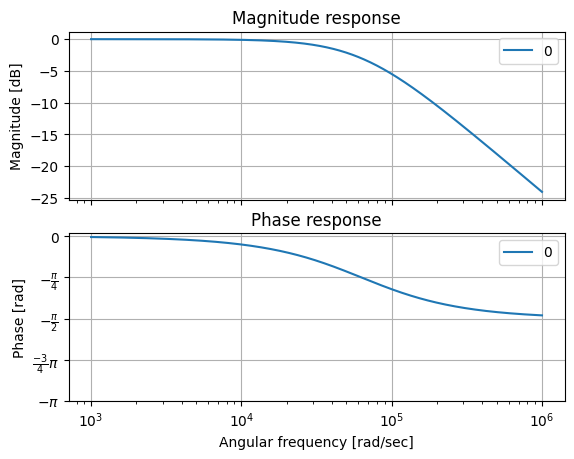

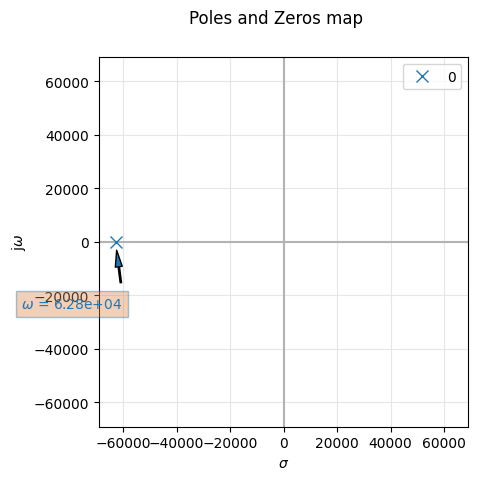

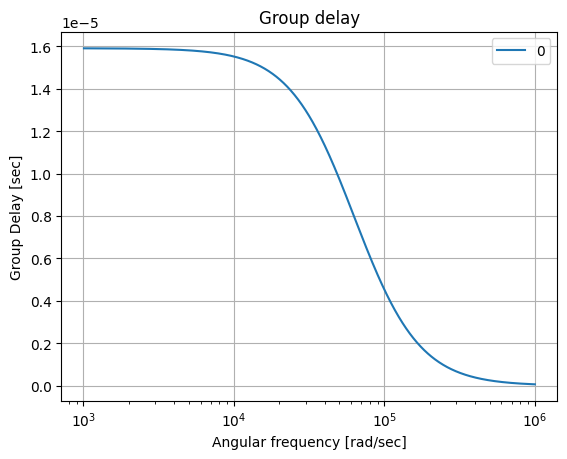

In [4]:
num_lp = [(R*C)**-1]
den_lp = [1,(R*C)**-1]
analyze_sys([sig.TransferFunction(num_lp, den_lp)])

<a name="consigna">
   <h3>Requisitos de diseño</h3>
</a> 

Los filtros deben cumplir con las condiciones y parámetros definidos en las siguientes plantillas:

<img src="./rsc/requisitos_filtros.png" align="center" width="683" height="533" />   



<a name="filtroA">
   <h3>Filtro A: FIR Pasa-bajos Equiripple</h3>
</a> 
Para el diseño de este filtro utilizaremos el software "PyFda".

Volcamos los valores de la plantilla para diseñar un filtro FIR pasa-bajos con equiripple.
<img src="./rsc/FIR1_config.png" align="center" width="357" height="469" />   
Se obtuvieron los coeficientes respectivos a 51 taps y el siguiente diagrama de polos y ceros:
<img src="./rsc/FIR1_polosYceros.png" align="center" width="907" height="472" />   
Se pone de manifiesto la estabilidad de los filtros FIR debido a que tienen todos sus polos en el origen, dentro de la circunferencia de radio unitario que representa el limite de la estabilidad (analogo al eje "jw" para el dominio analógico).

Verificamos que las respuestas de modulo y fase se condicen con los requisitos impuestos por la plantilla de diseño:
<img src="./rsc/FIR1_modulo.png" align="center" width="911" height="473" />   
<img src="./rsc/FIR1_fase.png" align="center" width="911" height="473" />   

<a name="filtroB">
   <h3>Filtro B: FIR Banda-suprimida</h3>
</a> 

En este caso vamos a emplear la función "firwin2" que provee la librería scipy.signal para diseñar el filtro de respuesta finita:

##### scipy.signal.firwin2(numtaps, freq, gain, nfreqs=None, window='hamming', nyq=None, antisymmetric=False, fs=None)

Recibe:
* numtaps: Cantidad de Taps.
* freq: Puntos de muestreo de frecuencia.
* gain: Vector de la misma forma que "bands" pero con los respectivos valores de ganancia por punto de muestreo.
* fs: Frecuencia de sampling
Devuelve:
* coeffs: Coeficientes del filtro FIR.

In [37]:
fs = 40000.0
nyq_frec = fs / 2
numtaps = 301
ripple = 1
atenuacion = 20
frecs = np.array([0, 2000, 4000, 6000, 8000, nyq_frec]) 
gains = np.array([-ripple, -ripple, -atenuacion, -atenuacion, -ripple, -ripple])
gains_veces = 10**(gains/20)
coeffs = sig.firwin2(numtaps, frecs, gains_veces , window='hamming', fs=fs)

Procedemos a analizar y graficar la respuesta en frecuencia de modulo, fase y retardo de grupo de la transferencia obtenida utilizando la función "freqz": 

##### scipy.signal.freqz(b, a=1, worN=512, whole=False, plot=None, fs=6.283185307179586, include_nyquist=False)
Recibe:
* b: Numerador de filtro lineal [array de 1 dimension].
* a: Denominador de filtro lineal [array de 1 dimension]. 
* worN: Cantidad de frecuencias para el computo [entero]

#####  scipy.signal.sosfreqz(sos, worN=512, whole=False, fs=6.283185307179586)[source]
Recibe:
* sos: Vector que contiene los coeficientes de las secciones de segundo orden.
* worN: Cantidad de frecuencias para el computo [entero]

Ambas funciones devuelven:
* w: Frecuencias en las cuales se calculó h normalizadas de 0 a pi. Misma unidad que fs.
* h: Números complejos que representan la respuesta en frecuencia del filtro.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


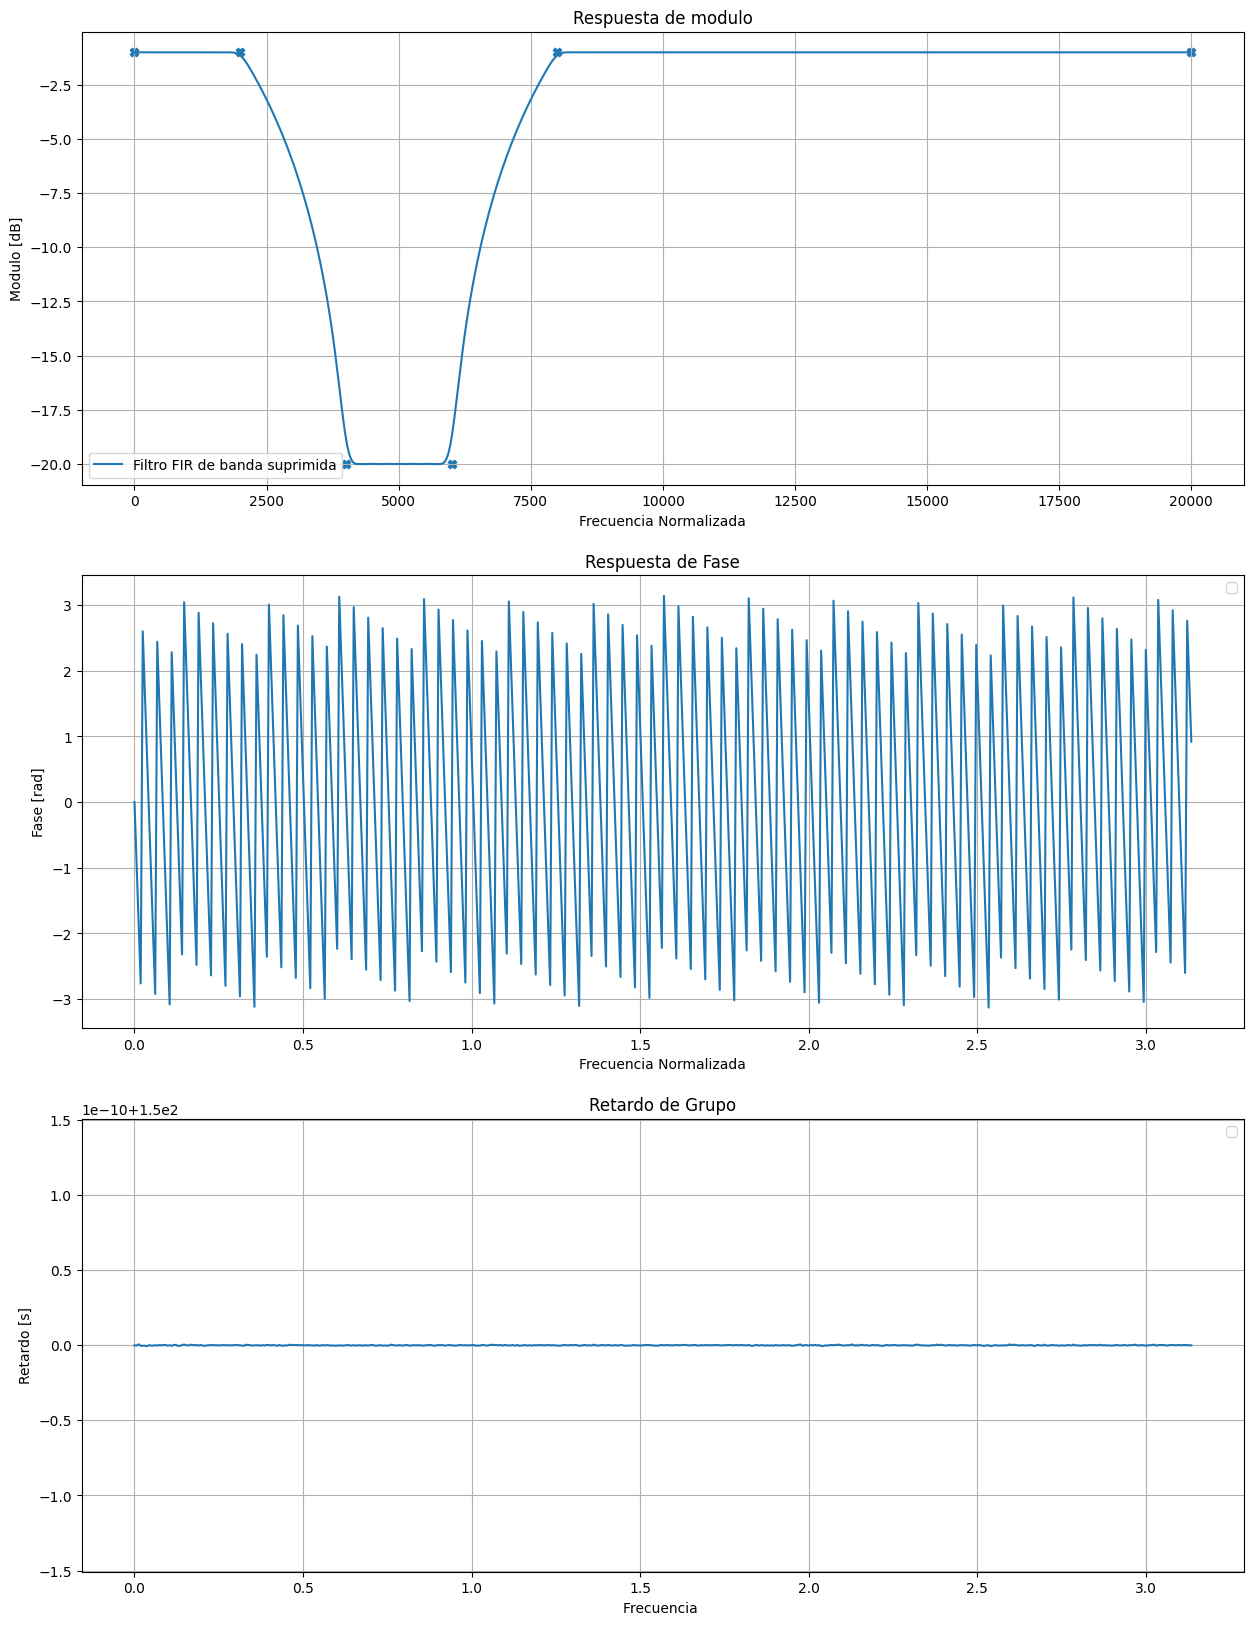

In [40]:
ww3, hh3 = sig.freqz(coeffs, 1.0)

#Graficos
fig, ax = plt.subplots(3,1, figsize = (15,20))

#Grafico de modulo
ax[0].plot(ww3*fs/(2*np.pi), 20*np.log10(np.abs(hh3)), label = 'Filtro FIR de banda suprimida')
ax[0].set_title('Respuesta de modulo')
ax[0].set_xlabel('Frecuencia Normalizada')
ax[0].set_ylabel('Modulo [dB]')
ax[0].grid()
ax[0].legend()
ax[0].scatter(frecs,gains, marker='X', cmap='summer')

#Grafico de fase
ax[1].plot(ww3, np.angle(hh3))
ax[1].set_title('Respuesta de Fase')
ax[1].set_xlabel('Frecuencia Normalizada')
ax[1].set_ylabel('Fase [rad]')
ax[1].grid()
ax[1].legend()

#Grafico de retardo de grupo
wz, d = sig.group_delay((coeffs,1), w=ww3, fs = fs)
ax[2].plot(wz, d)
ax[2].set_title('Retardo de Grupo')
ax[2].set_xlabel('Frecuencia ')
ax[2].set_ylabel('Retardo [s]')
ax[2].grid()
ax[2].legend()

Se destaca otra caracteristica propia de los filtros FIR que es el retardo de grupo constante.

<a name="filtroC">
   <h3>Filtro C: IIR Pasa-bajos Butterworth</h3>
</a> 
Para el diseño de este filtro utilizaremos nuevamente el software "PyFda".

Volcamos los valores de la plantilla para diseñar un filtro FIR pasa-bajos con equiripple.
<img src="./rsc/IIR_config.png" align="center" width="357" height="469" />   
En este caso se condicionó el diseño para que el filtro resultante sea de orden mínimo, originando el siguiente diagrama de polos y ceros:
<img src="./rsc/IIR_polosYceros.png" align="center" width="907" height="472" />   
El filtro tiene todos sus polos dentro de la circunferencia de radio unitario osea que es estable y ademas tiene los 8 ceros en pi es decir en altas frecuencias.
Verificamos que las respuestas de modulo y fase se condicen con los requisitos impuestos por la plantilla de diseño:
<img src="./rsc/IIR_modulo.png" align="center" width="911" height="473" />   
<img src="./rsc/IIR_fase.png" align="center" width="911" height="473" />   

<div class="alert alert-success text-left">
<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 
<center> 
    <a name="parte2">
        <h1> PARTE 2: Pruebas y Medición</h1>
    </a> 
</center>
</div>


<a name="bloques">
   <h3>Diagrama en bloques</h3>
</a> 
Para validar los filtros empleamos el siguiente setup de medición: 
<img src="./rsc/bloques.png" align="center" width="1196" height="599" />   
Con el fin de facilitar las practicas de laboratorio se disminuyó el orden de los filtros. Los coeficientes utilizados los calculó Federico Vizzon y se obtuvieron con la función "freqz" (ver anexo). 

<a name="osc">
   <h3>Mediciones con Osciloscopio</h3>
</a> 
Luego de relevar los datos de tensión a la entrada y a la salida de los filtros diseñados se obtiene la respuesta en frecuencia de modulo, fase y retardo de grupo:

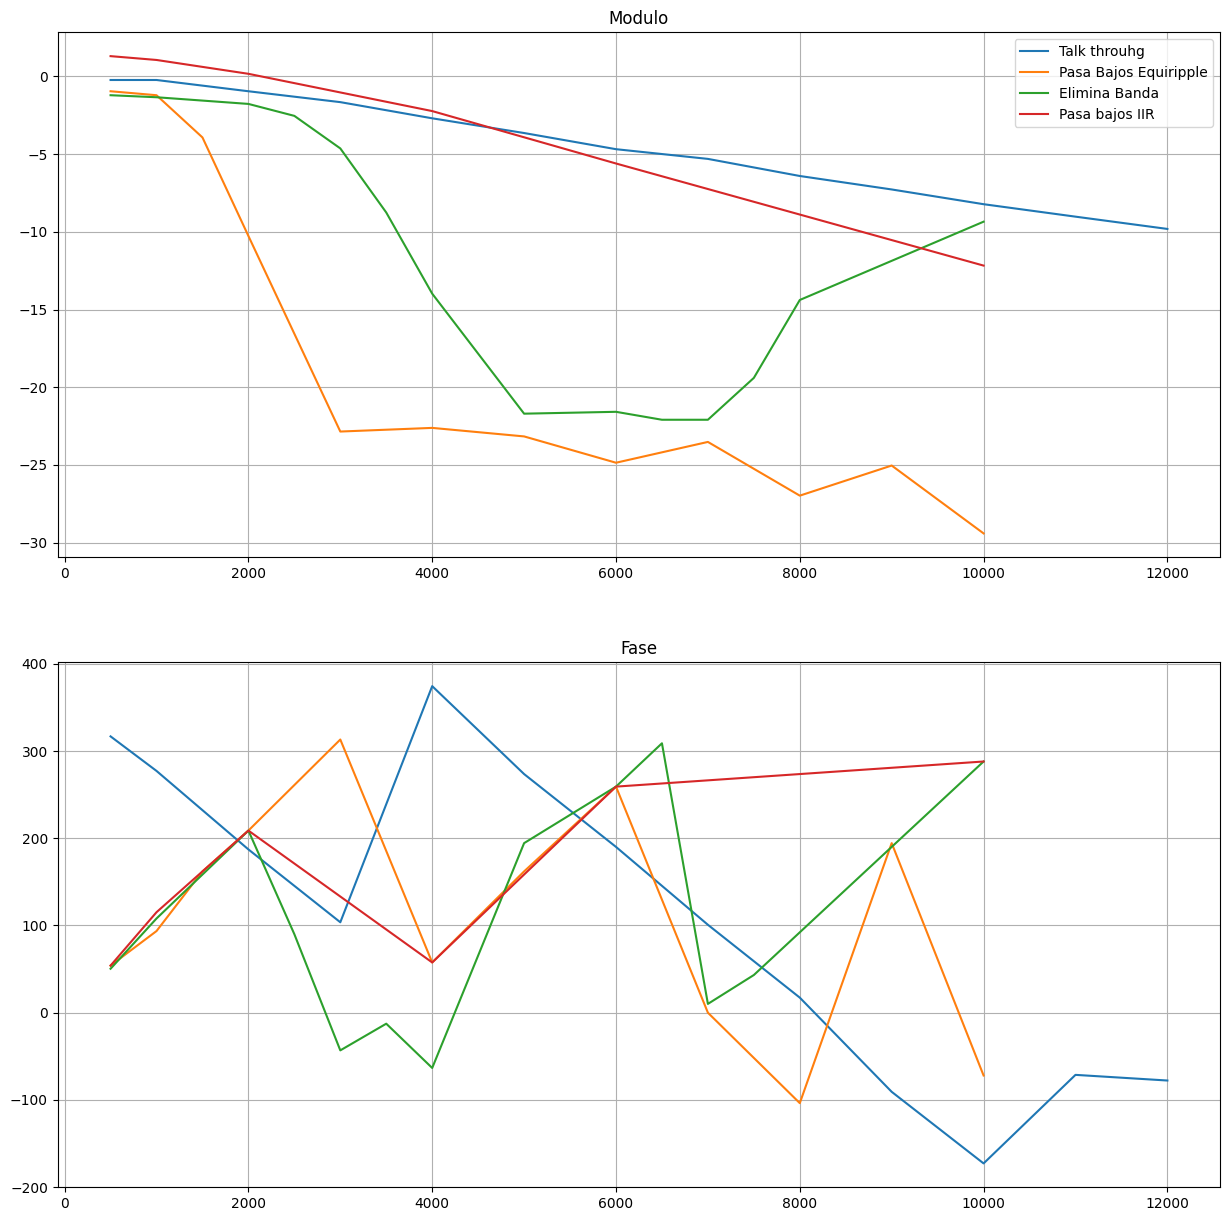

In [42]:
######################### Mediciones Manuales.
# Modulo y retrazo de senales en modo talkThrough
freqs_base_line = np.array([500,     1000,   2000,   3000,  4000,   5000,   6000,  7000,  8000, 9000,   10000,  11000, 12000])
times_base_line = np.array([1.76e-3, 770e-6, 260e-6, 96e-6, 260e-6, 152e-6, 88e-6, 40e-6, 6e-6, -28e-6, -48e-6, -18e-6, -18e-6])
vi_base_line = np.array([3.08, 3.08, 3.08, 3, 3, 2.92, 2.88, 2.8, 2.76, 2.68, 2.68, 2.6,  2.6])
vo_base_line = np.array([3, 3, 2.76, 2.48, 2.20, 1.92, 1.68, 1.52, 1.32, 1.16, 1.04, 0.92, 0.84])
phase_base_line = np.multiply(np.array(360*freqs_base_line), times_base_line)

# Modulo y retrazo para el filtro A
freqs_filter_a = np.array([500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
vi_filter_a = np.array(   [3.08, 3.08, 3.08, 3,    3,     2.92,  2.88, 2.8,  2.76,  2.68,  2.68, 2.6])
vo_filter_a = np.array(   [2.76, 2.68, 1.96, 0.92, 0.216, 0.216, 0.2,  0.16, 0.184, 0.12,  0.15, 0.088])
times_filter_a = np.array([300e-6, 260e-6, 300e-6, 290e-6, 290e-6, 40e-6, 90e-6, 120e-6, 0, -36e-6, 60e-6, -20e-6])
phase_filter_a = np.multiply(np.array(360*freqs_filter_a), times_filter_a)

# Modulo y retrazo para el filtro B
freqs_filter_b = np.array([500,    1000,   2000,   2500,   3000,   3500,   4000,   5000,   6000,   6500,  7000, 7500,   8000, 10000])
vi_filter_b = np.array(   [3.08,   3.08,   3.04,   3,      3,      2.96,   3,      2.92,   2.88,   2.8,    2.8,  2.8,   2.62,  2.64])
vo_filter_b = np.array(   [2.68,   2.64,    2.48,   2.24,   1.76,   1.08,   0.6,    0.24,   0.24,   0.22,  0.22, 0.3,   0.5,   0.9 ])
times_filter_b = np.array([280e-6, 300e-6, 290e-6, 100e-6, -40e-6, -10e-6, -44e-6, 108e-6, 120e-6, 132e-6, 4e-6, 16e-6, 32e-6, 80e-6])
phase_filter_b = np.multiply(np.array(360*freqs_filter_b), times_filter_b)

# Modulo y retrazo para el filtro C
freqs_filter_c = np.array([500,    1000,   2000,   4000,  6000,   10000])
vi_filter_c = np.array(   [3.08,   3.08,   3.04,   2.96,  2.84,   2.64])
vo_filter_c = np.array(   [3.58,   3.48,   3.1,    2.29,  1.49,   0.65])
times_filter_c = np.array([300e-6, 320e-6, 290e-6, 40e-6, 120e-6, 80e-6])
phase_filter_c = np.multiply(np.array(360*freqs_filter_c), times_filter_c)

amp_base_line = 20*np.log10(vo_base_line/vi_base_line)
amp_filter_a = 20*np.log10(vo_filter_a/vi_filter_a)
amp_filter_b = 20*np.log10(vo_filter_b/vi_filter_b)
amp_filter_c = 20*np.log10(vo_filter_c/vi_filter_c)

fig_man_1, ax_man_1 =  plt.subplots(2, 1, figsize = (15, 15))
ax_man_1[0].set_title('Modulo')
ax_man_1[0].plot(freqs_base_line, amp_base_line)
ax_man_1[0].plot(freqs_filter_a, amp_filter_a)
ax_man_1[0].plot(freqs_filter_b, amp_filter_b)
ax_man_1[0].plot(freqs_filter_c, amp_filter_c)
ax_man_1[0].legend(["Talk throuhg", "Pasa Bajos Equiripple", "Elimina Banda", "Pasa bajos IIR"])

ax_man_1[0].grid()
ax_man_1[1].set_title('Fase')
ax_man_1[1].plot(freqs_base_line, phase_base_line)
ax_man_1[1].plot(freqs_filter_a, phase_filter_a)
ax_man_1[1].plot(freqs_filter_b, phase_filter_b)
ax_man_1[1].plot(freqs_filter_c, phase_filter_c)
ax_man_1[0].legend(["Talk throuhg", "Pasa Bajos Equiripple", "Elimina Banda", "Pasa bajos IIR"])

ax_man_1[1].grid()

<a name="analizador">
   <h3>Mediciones con analizador de audio</h3>
</a> 

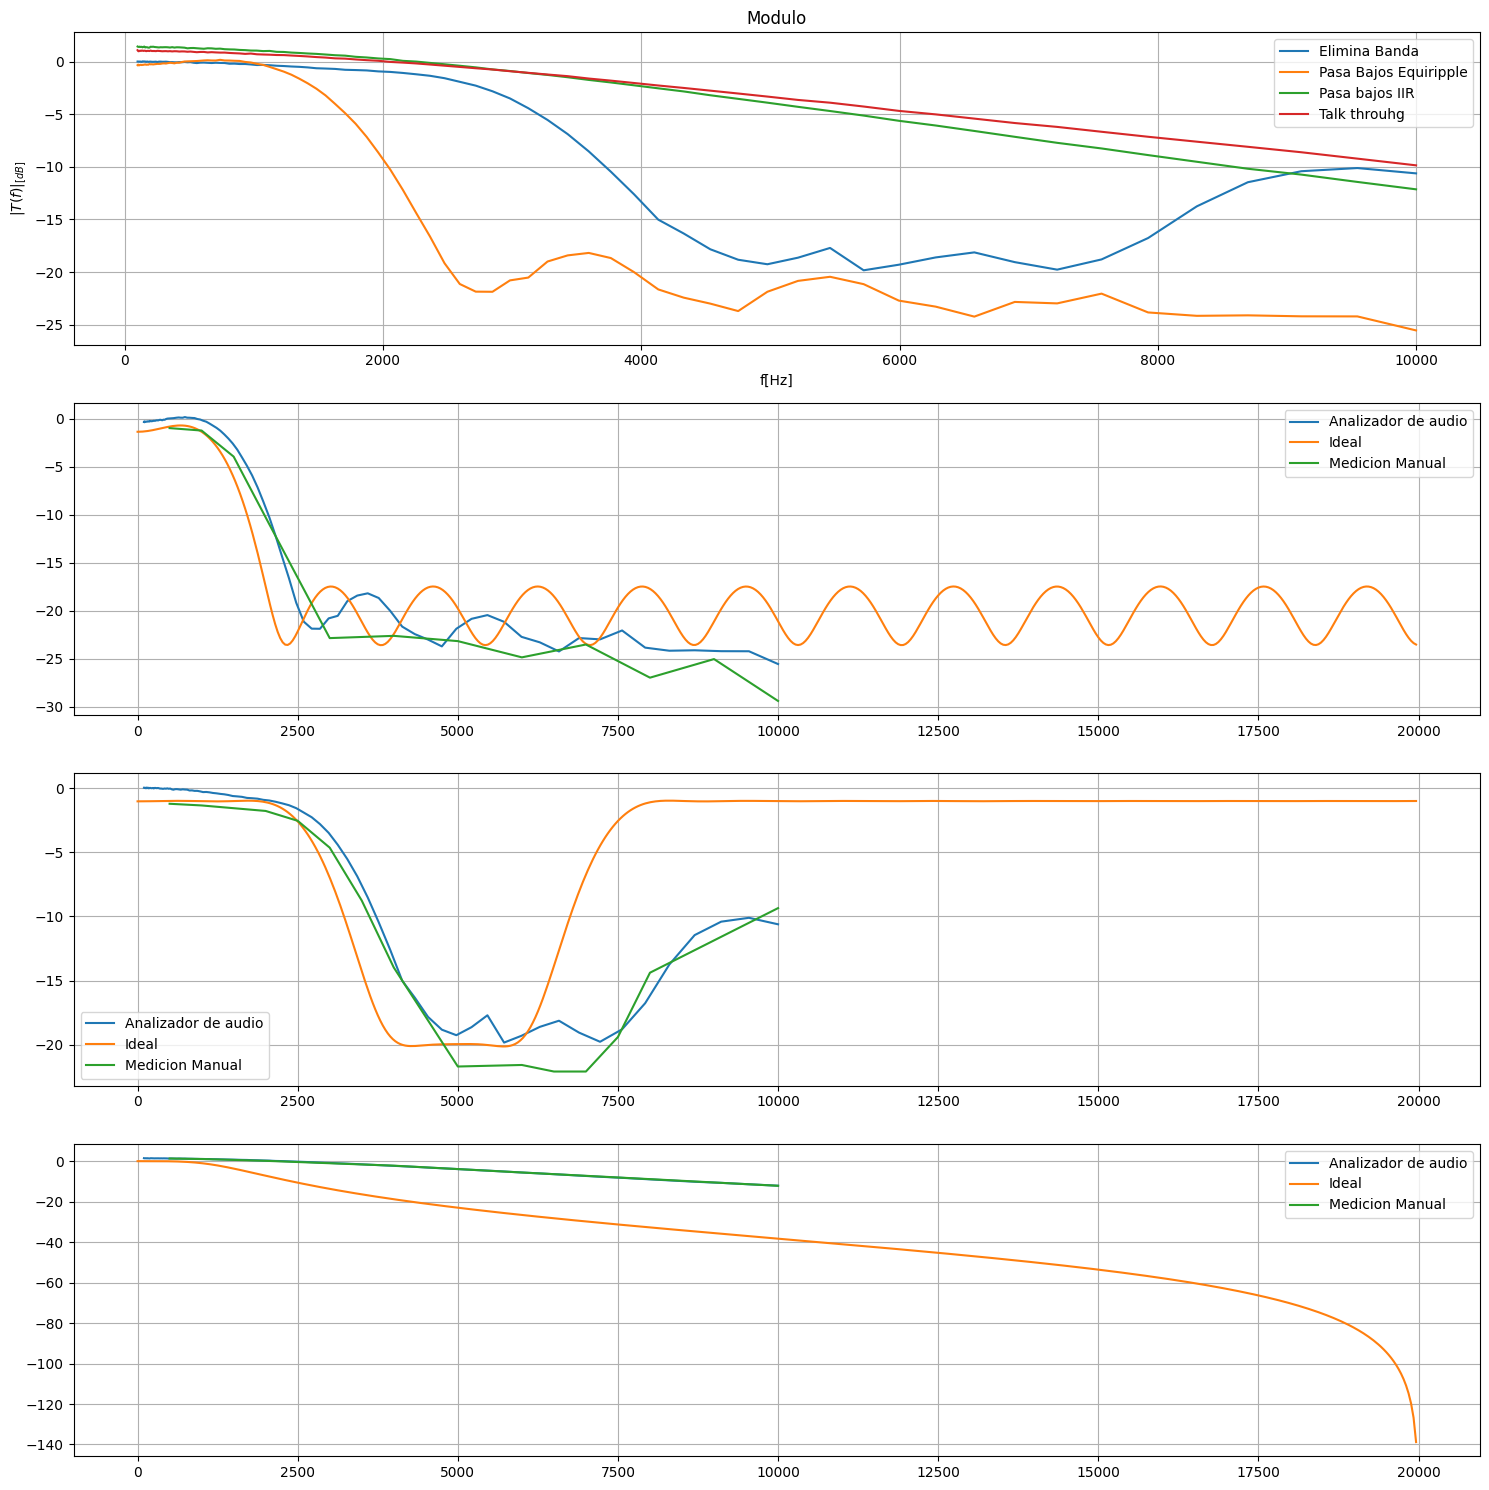

In [55]:
#levantamos los valores de modulo (previeamente descartamos el header y otro relleno del csv.)
# TODO obtener los valores con el analizado de audio y plotearlos junto a los valores obtenidos manualmente.
raw_data_0 = genfromtxt('csv/raw_data_0.csv', delimiter = ',') 
raw_data_1 = genfromtxt('csv/raw_data_1.csv', delimiter = ',')
raw_data_2 = genfromtxt('csv/raw_data_2.csv', delimiter = ',')
raw_data_3 = genfromtxt('csv/raw_data_3.csv', delimiter = ',')

freq_0 = raw_data_0[:,0]
mod_0 = raw_data_0[:,1]
freq_1 = raw_data_1[:,0]
mod_1 = raw_data_1[:,1]
freq_2 = raw_data_2[:,0]
mod_2 = raw_data_2[:,1]
freq_3 = raw_data_3[:,0]
mod_3 = raw_data_3[:,1]

#configuramos la cantidad de graficos, 3 filas 1 columna
figure, axes = plt.subplots(4,1, figsize=(15, 15))
axes[0].plot(freq_0, mod_0)
axes[0].plot(freq_1, mod_1)
axes[0].plot(freq_2, mod_2)
axes[0].plot(freq_3, mod_3)
axes[0].set_ylabel(r'$|T(f)|_{[dB]}$')
axes[0].set_xlabel('f[Hz]')
axes[0].grid()
axes[0].set_title("Modulo")
axes[0].legend(["Elimina Banda","Pasa Bajos Equiripple", "Pasa bajos IIR", "Talk throuhg"])
axes[1].plot(freq_1, mod_1, wz_a*fs/(2*np.pi), 20*np.log10(hz_a), freqs_filter_a, amp_filter_a)
axes[1].legend(["Analizador de audio","Ideal", "Medicion Manual"])
axes[1].grid()
axes[2].plot(freq_0, mod_0, wz_b*fs/(2*np.pi), 20*np.log10(hz_b), freqs_filter_b, amp_filter_b)
axes[2].legend(["Analizador de audio","Ideal", "Medicion Manual"])
axes[2].grid()
axes[3].plot(freq_2, mod_2, wz_c*fs/(2*np.pi), 20*np.log10(hz_c), freqs_filter_c, amp_filter_c)
axes[3].legend(["Analizador de audio","Ideal", "Medicion Manual"])
axes[3].grid()
#limitamos el grafico a los valores de frecuencia disponibles.
#axes[0].set_xlim([x_0_lower_limit, x_0_upper_limit])
#no limitamos en y, la libreria lo esta resolviendo mejor que nosotros.
#axes[0].set_ylim([y_0_lower_limit, y_0_upper_limit])
figure.tight_layout()

<div class="alert alert-success text-left">
<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 
<center> 
    <a name="conclusiones">
        <h1> CONCLUSIONES</h1>
    </a> 
</center>
</div>

1) Verificamos diferentes caracteristicas que presentan los filtros digitales como la estabilidad debido a que los polos de la función transferencia se localizan dentro de la circunferencia de radio unitario que, análogamente al eje jw en el dominio de Laplace (analógico), corresponde con el limite de estabilidad .En el caso de los filtros de respuesta finita verificamos la fase lineal y, por consecuencia el retardo de grupo constante. Para el filtro IIR no logramos obtener una respuesta debido a la inestabilidad que presentaba, por lo tanto efectuamos mediciones en un filtro de orden 1.
<br/><br/>
2) Durante la experiencia en el laboratorio notamos que la frecuencia de corte del filtro anti-alias y del filtro de interpolación definida inicialmente para 10kHz se había desplazado alrededor de los 7kHz. Este desplazamiento afectó la respuesta en frecuencia principalmente del filtro de banda suprimida que tenía su segunda banda de paso a partir de los 8kHz. La causa de esta traslación de la frecuencia de corte fue la mala calidad de los componentes pasivos utilizados y la gran dispersión que presentaban con respecto a su valor nominal, lo que evidencia que resulta muy conveniente analizar la sensibilidad de los parámetros del filtro ante la variación del valor de los componentes durante la etapa de diseño (por ej. mediante una simulación de Montecarlo).
<br/><br/>
3) Debido al bajo muestreo de puntos no nos resultó posible graficar la fase y por lo tanto tampoco pudimos obtener el retardo de grupo para verificar las respuestas en frecuencia obtenidas durante el diseño de los filtros.
<br/><br/>
4) Logramos llevar a la práctica la teoría moderna de filtros y comprobar empíricamente que el comportamiento de los filtros se condice con el diseño realizado a partir de las plantillas impuestas.

<div class="alert alert-success text-left">
<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 
<center> 
    <a name="anexo">
        <h1> ANEXO: VECTORES DE FRECUENCIAS</h1>
    </a> 
</center>
</div>
A continuación se presentan las frecuencias obtenidas por la función "freqz" en los filtros diseñados por Federico Vizzon, cuyos coeficientes fueron los que se emplearon durante el laboratorio de filtrado digital.

In [49]:
wz_a = np.array([0.        , 0.00613592, 0.01227185, 0.01840777, 0.02454369,
       0.03067962, 0.03681554, 0.04295146, 0.04908739, 0.05522331,
       0.06135923, 0.06749515, 0.07363108, 0.079767  , 0.08590292,
       0.09203885, 0.09817477, 0.10431069, 0.11044662, 0.11658254,
       0.12271846, 0.12885439, 0.13499031, 0.14112623, 0.14726216,
       0.15339808, 0.159534  , 0.16566993, 0.17180585, 0.17794177,
       0.18407769, 0.19021362, 0.19634954, 0.20248546, 0.20862139,
       0.21475731, 0.22089323, 0.22702916, 0.23316508, 0.239301  ,
       0.24543693, 0.25157285, 0.25770877, 0.2638447 , 0.26998062,
       0.27611654, 0.28225246, 0.28838839, 0.29452431, 0.30066023,
       0.30679616, 0.31293208, 0.319068  , 0.32520393, 0.33133985,
       0.33747577, 0.3436117 , 0.34974762, 0.35588354, 0.36201947,
       0.36815539, 0.37429131, 0.38042724, 0.38656316, 0.39269908,
       0.398835  , 0.40497093, 0.41110685, 0.41724277, 0.4233787 ,
       0.42951462, 0.43565054, 0.44178647, 0.44792239, 0.45405831,
       0.46019424, 0.46633016, 0.47246608, 0.47860201, 0.48473793,
       0.49087385, 0.49700978, 0.5031457 , 0.50928162, 0.51541754,
       0.52155347, 0.52768939, 0.53382531, 0.53996124, 0.54609716,
       0.55223308, 0.55836901, 0.56450493, 0.57064085, 0.57677678,
       0.5829127 , 0.58904862, 0.59518455, 0.60132047, 0.60745639,
       0.61359232, 0.61972824, 0.62586416, 0.63200008, 0.63813601,
       0.64427193, 0.65040785, 0.65654378, 0.6626797 , 0.66881562,
       0.67495155, 0.68108747, 0.68722339, 0.69335932, 0.69949524,
       0.70563116, 0.71176709, 0.71790301, 0.72403893, 0.73017486,
       0.73631078, 0.7424467 , 0.74858262, 0.75471855, 0.76085447,
       0.76699039, 0.77312632, 0.77926224, 0.78539816, 0.79153409,
       0.79767001, 0.80380593, 0.80994186, 0.81607778, 0.8222137 ,
       0.82834963, 0.83448555, 0.84062147, 0.84675739, 0.85289332,
       0.85902924, 0.86516516, 0.87130109, 0.87743701, 0.88357293,
       0.88970886, 0.89584478, 0.9019807 , 0.90811663, 0.91425255,
       0.92038847, 0.9265244 , 0.93266032, 0.93879624, 0.94493217,
       0.95106809, 0.95720401, 0.96333993, 0.96947586, 0.97561178,
       0.9817477 , 0.98788363, 0.99401955, 1.00015547, 1.0062914 ,
       1.01242732, 1.01856324, 1.02469917, 1.03083509, 1.03697101,
       1.04310694, 1.04924286, 1.05537878, 1.06151471, 1.06765063,
       1.07378655, 1.07992247, 1.0860584 , 1.09219432, 1.09833024,
       1.10446617, 1.11060209, 1.11673801, 1.12287394, 1.12900986,
       1.13514578, 1.14128171, 1.14741763, 1.15355355, 1.15968948,
       1.1658254 , 1.17196132, 1.17809725, 1.18423317, 1.19036909,
       1.19650501, 1.20264094, 1.20877686, 1.21491278, 1.22104871,
       1.22718463, 1.23332055, 1.23945648, 1.2455924 , 1.25172832,
       1.25786425, 1.26400017, 1.27013609, 1.27627202, 1.28240794,
       1.28854386, 1.29467978, 1.30081571, 1.30695163, 1.31308755,
       1.31922348, 1.3253594 , 1.33149532, 1.33763125, 1.34376717,
       1.34990309, 1.35603902, 1.36217494, 1.36831086, 1.37444679,
       1.38058271, 1.38671863, 1.39285456, 1.39899048, 1.4051264 ,
       1.41126232, 1.41739825, 1.42353417, 1.42967009, 1.43580602,
       1.44194194, 1.44807786, 1.45421379, 1.46034971, 1.46648563,
       1.47262156, 1.47875748, 1.4848934 , 1.49102933, 1.49716525,
       1.50330117, 1.5094371 , 1.51557302, 1.52170894, 1.52784486,
       1.53398079, 1.54011671, 1.54625263, 1.55238856, 1.55852448,
       1.5646604 , 1.57079633, 1.57693225, 1.58306817, 1.5892041 ,
       1.59534002, 1.60147594, 1.60761187, 1.61374779, 1.61988371,
       1.62601964, 1.63215556, 1.63829148, 1.6444274 , 1.65056333,
       1.65669925, 1.66283517, 1.6689711 , 1.67510702, 1.68124294,
       1.68737887, 1.69351479, 1.69965071, 1.70578664, 1.71192256,
       1.71805848, 1.72419441, 1.73033033, 1.73646625, 1.74260218,
       1.7487381 , 1.75487402, 1.76100994, 1.76714587, 1.77328179,
       1.77941771, 1.78555364, 1.79168956, 1.79782548, 1.80396141,
       1.81009733, 1.81623325, 1.82236918, 1.8285051 , 1.83464102,
       1.84077695, 1.84691287, 1.85304879, 1.85918471, 1.86532064,
       1.87145656, 1.87759248, 1.88372841, 1.88986433, 1.89600025,
       1.90213618, 1.9082721 , 1.91440802, 1.92054395, 1.92667987,
       1.93281579, 1.93895172, 1.94508764, 1.95122356, 1.95735949,
       1.96349541, 1.96963133, 1.97576725, 1.98190318, 1.9880391 ,
       1.99417502, 2.00031095, 2.00644687, 2.01258279, 2.01871872,
       2.02485464, 2.03099056, 2.03712649, 2.04326241, 2.04939833,
       2.05553426, 2.06167018, 2.0678061 , 2.07394203, 2.08007795,
       2.08621387, 2.09234979, 2.09848572, 2.10462164, 2.11075756,
       2.11689349, 2.12302941, 2.12916533, 2.13530126, 2.14143718,
       2.1475731 , 2.15370903, 2.15984495, 2.16598087, 2.1721168 ,
       2.17825272, 2.18438864, 2.19052457, 2.19666049, 2.20279641,
       2.20893233, 2.21506826, 2.22120418, 2.2273401 , 2.23347603,
       2.23961195, 2.24574787, 2.2518838 , 2.25801972, 2.26415564,
       2.27029157, 2.27642749, 2.28256341, 2.28869934, 2.29483526,
       2.30097118, 2.3071071 , 2.31324303, 2.31937895, 2.32551487,
       2.3316508 , 2.33778672, 2.34392264, 2.35005857, 2.35619449,
       2.36233041, 2.36846634, 2.37460226, 2.38073818, 2.38687411,
       2.39301003, 2.39914595, 2.40528188, 2.4114178 , 2.41755372,
       2.42368964, 2.42982557, 2.43596149, 2.44209741, 2.44823334,
       2.45436926, 2.46050518, 2.46664111, 2.47277703, 2.47891295,
       2.48504888, 2.4911848 , 2.49732072, 2.50345665, 2.50959257,
       2.51572849, 2.52186442, 2.52800034, 2.53413626, 2.54027218,
       2.54640811, 2.55254403, 2.55867995, 2.56481588, 2.5709518 ,
       2.57708772, 2.58322365, 2.58935957, 2.59549549, 2.60163142,
       2.60776734, 2.61390326, 2.62003919, 2.62617511, 2.63231103,
       2.63844696, 2.64458288, 2.6507188 , 2.65685472, 2.66299065,
       2.66912657, 2.67526249, 2.68139842, 2.68753434, 2.69367026,
       2.69980619, 2.70594211, 2.71207803, 2.71821396, 2.72434988,
       2.7304858 , 2.73662173, 2.74275765, 2.74889357, 2.7550295 ,
       2.76116542, 2.76730134, 2.77343726, 2.77957319, 2.78570911,
       2.79184503, 2.79798096, 2.80411688, 2.8102528 , 2.81638873,
       2.82252465, 2.82866057, 2.8347965 , 2.84093242, 2.84706834,
       2.85320427, 2.85934019, 2.86547611, 2.87161203, 2.87774796,
       2.88388388, 2.8900198 , 2.89615573, 2.90229165, 2.90842757,
       2.9145635 , 2.92069942, 2.92683534, 2.93297127, 2.93910719,
       2.94524311, 2.95137904, 2.95751496, 2.96365088, 2.96978681,
       2.97592273, 2.98205865, 2.98819457, 2.9943305 , 3.00046642,
       3.00660234, 3.01273827, 3.01887419, 3.02501011, 3.03114604,
       3.03728196, 3.04341788, 3.04955381, 3.05568973, 3.06182565,
       3.06796158, 3.0740975 , 3.08023342, 3.08636935, 3.09250527,
       3.09864119, 3.10477711, 3.11091304, 3.11704896, 3.12318488,
       3.12932081, 3.13545673])

In [52]:
wz_b = np.array([0.        , 0.00613592, 0.01227185, 0.01840777, 0.02454369,
       0.03067962, 0.03681554, 0.04295146, 0.04908739, 0.05522331,
       0.06135923, 0.06749515, 0.07363108, 0.079767  , 0.08590292,
       0.09203885, 0.09817477, 0.10431069, 0.11044662, 0.11658254,
       0.12271846, 0.12885439, 0.13499031, 0.14112623, 0.14726216,
       0.15339808, 0.159534  , 0.16566993, 0.17180585, 0.17794177,
       0.18407769, 0.19021362, 0.19634954, 0.20248546, 0.20862139,
       0.21475731, 0.22089323, 0.22702916, 0.23316508, 0.239301  ,
       0.24543693, 0.25157285, 0.25770877, 0.2638447 , 0.26998062,
       0.27611654, 0.28225246, 0.28838839, 0.29452431, 0.30066023,
       0.30679616, 0.31293208, 0.319068  , 0.32520393, 0.33133985,
       0.33747577, 0.3436117 , 0.34974762, 0.35588354, 0.36201947,
       0.36815539, 0.37429131, 0.38042724, 0.38656316, 0.39269908,
       0.398835  , 0.40497093, 0.41110685, 0.41724277, 0.4233787 ,
       0.42951462, 0.43565054, 0.44178647, 0.44792239, 0.45405831,
       0.46019424, 0.46633016, 0.47246608, 0.47860201, 0.48473793,
       0.49087385, 0.49700978, 0.5031457 , 0.50928162, 0.51541754,
       0.52155347, 0.52768939, 0.53382531, 0.53996124, 0.54609716,
       0.55223308, 0.55836901, 0.56450493, 0.57064085, 0.57677678,
       0.5829127 , 0.58904862, 0.59518455, 0.60132047, 0.60745639,
       0.61359232, 0.61972824, 0.62586416, 0.63200008, 0.63813601,
       0.64427193, 0.65040785, 0.65654378, 0.6626797 , 0.66881562,
       0.67495155, 0.68108747, 0.68722339, 0.69335932, 0.69949524,
       0.70563116, 0.71176709, 0.71790301, 0.72403893, 0.73017486,
       0.73631078, 0.7424467 , 0.74858262, 0.75471855, 0.76085447,
       0.76699039, 0.77312632, 0.77926224, 0.78539816, 0.79153409,
       0.79767001, 0.80380593, 0.80994186, 0.81607778, 0.8222137 ,
       0.82834963, 0.83448555, 0.84062147, 0.84675739, 0.85289332,
       0.85902924, 0.86516516, 0.87130109, 0.87743701, 0.88357293,
       0.88970886, 0.89584478, 0.9019807 , 0.90811663, 0.91425255,
       0.92038847, 0.9265244 , 0.93266032, 0.93879624, 0.94493217,
       0.95106809, 0.95720401, 0.96333993, 0.96947586, 0.97561178,
       0.9817477 , 0.98788363, 0.99401955, 1.00015547, 1.0062914 ,
       1.01242732, 1.01856324, 1.02469917, 1.03083509, 1.03697101,
       1.04310694, 1.04924286, 1.05537878, 1.06151471, 1.06765063,
       1.07378655, 1.07992247, 1.0860584 , 1.09219432, 1.09833024,
       1.10446617, 1.11060209, 1.11673801, 1.12287394, 1.12900986,
       1.13514578, 1.14128171, 1.14741763, 1.15355355, 1.15968948,
       1.1658254 , 1.17196132, 1.17809725, 1.18423317, 1.19036909,
       1.19650501, 1.20264094, 1.20877686, 1.21491278, 1.22104871,
       1.22718463, 1.23332055, 1.23945648, 1.2455924 , 1.25172832,
       1.25786425, 1.26400017, 1.27013609, 1.27627202, 1.28240794,
       1.28854386, 1.29467978, 1.30081571, 1.30695163, 1.31308755,
       1.31922348, 1.3253594 , 1.33149532, 1.33763125, 1.34376717,
       1.34990309, 1.35603902, 1.36217494, 1.36831086, 1.37444679,
       1.38058271, 1.38671863, 1.39285456, 1.39899048, 1.4051264 ,
       1.41126232, 1.41739825, 1.42353417, 1.42967009, 1.43580602,
       1.44194194, 1.44807786, 1.45421379, 1.46034971, 1.46648563,
       1.47262156, 1.47875748, 1.4848934 , 1.49102933, 1.49716525,
       1.50330117, 1.5094371 , 1.51557302, 1.52170894, 1.52784486,
       1.53398079, 1.54011671, 1.54625263, 1.55238856, 1.55852448,
       1.5646604 , 1.57079633, 1.57693225, 1.58306817, 1.5892041 ,
       1.59534002, 1.60147594, 1.60761187, 1.61374779, 1.61988371,
       1.62601964, 1.63215556, 1.63829148, 1.6444274 , 1.65056333,
       1.65669925, 1.66283517, 1.6689711 , 1.67510702, 1.68124294,
       1.68737887, 1.69351479, 1.69965071, 1.70578664, 1.71192256,
       1.71805848, 1.72419441, 1.73033033, 1.73646625, 1.74260218,
       1.7487381 , 1.75487402, 1.76100994, 1.76714587, 1.77328179,
       1.77941771, 1.78555364, 1.79168956, 1.79782548, 1.80396141,
       1.81009733, 1.81623325, 1.82236918, 1.8285051 , 1.83464102,
       1.84077695, 1.84691287, 1.85304879, 1.85918471, 1.86532064,
       1.87145656, 1.87759248, 1.88372841, 1.88986433, 1.89600025,
       1.90213618, 1.9082721 , 1.91440802, 1.92054395, 1.92667987,
       1.93281579, 1.93895172, 1.94508764, 1.95122356, 1.95735949,
       1.96349541, 1.96963133, 1.97576725, 1.98190318, 1.9880391 ,
       1.99417502, 2.00031095, 2.00644687, 2.01258279, 2.01871872,
       2.02485464, 2.03099056, 2.03712649, 2.04326241, 2.04939833,
       2.05553426, 2.06167018, 2.0678061 , 2.07394203, 2.08007795,
       2.08621387, 2.09234979, 2.09848572, 2.10462164, 2.11075756,
       2.11689349, 2.12302941, 2.12916533, 2.13530126, 2.14143718,
       2.1475731 , 2.15370903, 2.15984495, 2.16598087, 2.1721168 ,
       2.17825272, 2.18438864, 2.19052457, 2.19666049, 2.20279641,
       2.20893233, 2.21506826, 2.22120418, 2.2273401 , 2.23347603,
       2.23961195, 2.24574787, 2.2518838 , 2.25801972, 2.26415564,
       2.27029157, 2.27642749, 2.28256341, 2.28869934, 2.29483526,
       2.30097118, 2.3071071 , 2.31324303, 2.31937895, 2.32551487,
       2.3316508 , 2.33778672, 2.34392264, 2.35005857, 2.35619449,
       2.36233041, 2.36846634, 2.37460226, 2.38073818, 2.38687411,
       2.39301003, 2.39914595, 2.40528188, 2.4114178 , 2.41755372,
       2.42368964, 2.42982557, 2.43596149, 2.44209741, 2.44823334,
       2.45436926, 2.46050518, 2.46664111, 2.47277703, 2.47891295,
       2.48504888, 2.4911848 , 2.49732072, 2.50345665, 2.50959257,
       2.51572849, 2.52186442, 2.52800034, 2.53413626, 2.54027218,
       2.54640811, 2.55254403, 2.55867995, 2.56481588, 2.5709518 ,
       2.57708772, 2.58322365, 2.58935957, 2.59549549, 2.60163142,
       2.60776734, 2.61390326, 2.62003919, 2.62617511, 2.63231103,
       2.63844696, 2.64458288, 2.6507188 , 2.65685472, 2.66299065,
       2.66912657, 2.67526249, 2.68139842, 2.68753434, 2.69367026,
       2.69980619, 2.70594211, 2.71207803, 2.71821396, 2.72434988,
       2.7304858 , 2.73662173, 2.74275765, 2.74889357, 2.7550295 ,
       2.76116542, 2.76730134, 2.77343726, 2.77957319, 2.78570911,
       2.79184503, 2.79798096, 2.80411688, 2.8102528 , 2.81638873,
       2.82252465, 2.82866057, 2.8347965 , 2.84093242, 2.84706834,
       2.85320427, 2.85934019, 2.86547611, 2.87161203, 2.87774796,
       2.88388388, 2.8900198 , 2.89615573, 2.90229165, 2.90842757,
       2.9145635 , 2.92069942, 2.92683534, 2.93297127, 2.93910719,
       2.94524311, 2.95137904, 2.95751496, 2.96365088, 2.96978681,
       2.97592273, 2.98205865, 2.98819457, 2.9943305 , 3.00046642,
       3.00660234, 3.01273827, 3.01887419, 3.02501011, 3.03114604,
       3.03728196, 3.04341788, 3.04955381, 3.05568973, 3.06182565,
       3.06796158, 3.0740975 , 3.08023342, 3.08636935, 3.09250527,
       3.09864119, 3.10477711, 3.11091304, 3.11704896, 3.12318488,
       3.12932081, 3.13545673])

In [54]:
wz_c = np.array([0.        , 0.00613592, 0.01227185, 0.01840777, 0.02454369,
       0.03067962, 0.03681554, 0.04295146, 0.04908739, 0.05522331,
       0.06135923, 0.06749515, 0.07363108, 0.079767  , 0.08590292,
       0.09203885, 0.09817477, 0.10431069, 0.11044662, 0.11658254,
       0.12271846, 0.12885439, 0.13499031, 0.14112623, 0.14726216,
       0.15339808, 0.159534  , 0.16566993, 0.17180585, 0.17794177,
       0.18407769, 0.19021362, 0.19634954, 0.20248546, 0.20862139,
       0.21475731, 0.22089323, 0.22702916, 0.23316508, 0.239301  ,
       0.24543693, 0.25157285, 0.25770877, 0.2638447 , 0.26998062,
       0.27611654, 0.28225246, 0.28838839, 0.29452431, 0.30066023,
       0.30679616, 0.31293208, 0.319068  , 0.32520393, 0.33133985,
       0.33747577, 0.3436117 , 0.34974762, 0.35588354, 0.36201947,
       0.36815539, 0.37429131, 0.38042724, 0.38656316, 0.39269908,
       0.398835  , 0.40497093, 0.41110685, 0.41724277, 0.4233787 ,
       0.42951462, 0.43565054, 0.44178647, 0.44792239, 0.45405831,
       0.46019424, 0.46633016, 0.47246608, 0.47860201, 0.48473793,
       0.49087385, 0.49700978, 0.5031457 , 0.50928162, 0.51541754,
       0.52155347, 0.52768939, 0.53382531, 0.53996124, 0.54609716,
       0.55223308, 0.55836901, 0.56450493, 0.57064085, 0.57677678,
       0.5829127 , 0.58904862, 0.59518455, 0.60132047, 0.60745639,
       0.61359232, 0.61972824, 0.62586416, 0.63200008, 0.63813601,
       0.64427193, 0.65040785, 0.65654378, 0.6626797 , 0.66881562,
       0.67495155, 0.68108747, 0.68722339, 0.69335932, 0.69949524,
       0.70563116, 0.71176709, 0.71790301, 0.72403893, 0.73017486,
       0.73631078, 0.7424467 , 0.74858262, 0.75471855, 0.76085447,
       0.76699039, 0.77312632, 0.77926224, 0.78539816, 0.79153409,
       0.79767001, 0.80380593, 0.80994186, 0.81607778, 0.8222137 ,
       0.82834963, 0.83448555, 0.84062147, 0.84675739, 0.85289332,
       0.85902924, 0.86516516, 0.87130109, 0.87743701, 0.88357293,
       0.88970886, 0.89584478, 0.9019807 , 0.90811663, 0.91425255,
       0.92038847, 0.9265244 , 0.93266032, 0.93879624, 0.94493217,
       0.95106809, 0.95720401, 0.96333993, 0.96947586, 0.97561178,
       0.9817477 , 0.98788363, 0.99401955, 1.00015547, 1.0062914 ,
       1.01242732, 1.01856324, 1.02469917, 1.03083509, 1.03697101,
       1.04310694, 1.04924286, 1.05537878, 1.06151471, 1.06765063,
       1.07378655, 1.07992247, 1.0860584 , 1.09219432, 1.09833024,
       1.10446617, 1.11060209, 1.11673801, 1.12287394, 1.12900986,
       1.13514578, 1.14128171, 1.14741763, 1.15355355, 1.15968948,
       1.1658254 , 1.17196132, 1.17809725, 1.18423317, 1.19036909,
       1.19650501, 1.20264094, 1.20877686, 1.21491278, 1.22104871,
       1.22718463, 1.23332055, 1.23945648, 1.2455924 , 1.25172832,
       1.25786425, 1.26400017, 1.27013609, 1.27627202, 1.28240794,
       1.28854386, 1.29467978, 1.30081571, 1.30695163, 1.31308755,
       1.31922348, 1.3253594 , 1.33149532, 1.33763125, 1.34376717,
       1.34990309, 1.35603902, 1.36217494, 1.36831086, 1.37444679,
       1.38058271, 1.38671863, 1.39285456, 1.39899048, 1.4051264 ,
       1.41126232, 1.41739825, 1.42353417, 1.42967009, 1.43580602,
       1.44194194, 1.44807786, 1.45421379, 1.46034971, 1.46648563,
       1.47262156, 1.47875748, 1.4848934 , 1.49102933, 1.49716525,
       1.50330117, 1.5094371 , 1.51557302, 1.52170894, 1.52784486,
       1.53398079, 1.54011671, 1.54625263, 1.55238856, 1.55852448,
       1.5646604 , 1.57079633, 1.57693225, 1.58306817, 1.5892041 ,
       1.59534002, 1.60147594, 1.60761187, 1.61374779, 1.61988371,
       1.62601964, 1.63215556, 1.63829148, 1.6444274 , 1.65056333,
       1.65669925, 1.66283517, 1.6689711 , 1.67510702, 1.68124294,
       1.68737887, 1.69351479, 1.69965071, 1.70578664, 1.71192256,
       1.71805848, 1.72419441, 1.73033033, 1.73646625, 1.74260218,
       1.7487381 , 1.75487402, 1.76100994, 1.76714587, 1.77328179,
       1.77941771, 1.78555364, 1.79168956, 1.79782548, 1.80396141,
       1.81009733, 1.81623325, 1.82236918, 1.8285051 , 1.83464102,
       1.84077695, 1.84691287, 1.85304879, 1.85918471, 1.86532064,
       1.87145656, 1.87759248, 1.88372841, 1.88986433, 1.89600025,
       1.90213618, 1.9082721 , 1.91440802, 1.92054395, 1.92667987,
       1.93281579, 1.93895172, 1.94508764, 1.95122356, 1.95735949,
       1.96349541, 1.96963133, 1.97576725, 1.98190318, 1.9880391 ,
       1.99417502, 2.00031095, 2.00644687, 2.01258279, 2.01871872,
       2.02485464, 2.03099056, 2.03712649, 2.04326241, 2.04939833,
       2.05553426, 2.06167018, 2.0678061 , 2.07394203, 2.08007795,
       2.08621387, 2.09234979, 2.09848572, 2.10462164, 2.11075756,
       2.11689349, 2.12302941, 2.12916533, 2.13530126, 2.14143718,
       2.1475731 , 2.15370903, 2.15984495, 2.16598087, 2.1721168 ,
       2.17825272, 2.18438864, 2.19052457, 2.19666049, 2.20279641,
       2.20893233, 2.21506826, 2.22120418, 2.2273401 , 2.23347603,
       2.23961195, 2.24574787, 2.2518838 , 2.25801972, 2.26415564,
       2.27029157, 2.27642749, 2.28256341, 2.28869934, 2.29483526,
       2.30097118, 2.3071071 , 2.31324303, 2.31937895, 2.32551487,
       2.3316508 , 2.33778672, 2.34392264, 2.35005857, 2.35619449,
       2.36233041, 2.36846634, 2.37460226, 2.38073818, 2.38687411,
       2.39301003, 2.39914595, 2.40528188, 2.4114178 , 2.41755372,
       2.42368964, 2.42982557, 2.43596149, 2.44209741, 2.44823334,
       2.45436926, 2.46050518, 2.46664111, 2.47277703, 2.47891295,
       2.48504888, 2.4911848 , 2.49732072, 2.50345665, 2.50959257,
       2.51572849, 2.52186442, 2.52800034, 2.53413626, 2.54027218,
       2.54640811, 2.55254403, 2.55867995, 2.56481588, 2.5709518 ,
       2.57708772, 2.58322365, 2.58935957, 2.59549549, 2.60163142,
       2.60776734, 2.61390326, 2.62003919, 2.62617511, 2.63231103,
       2.63844696, 2.64458288, 2.6507188 , 2.65685472, 2.66299065,
       2.66912657, 2.67526249, 2.68139842, 2.68753434, 2.69367026,
       2.69980619, 2.70594211, 2.71207803, 2.71821396, 2.72434988,
       2.7304858 , 2.73662173, 2.74275765, 2.74889357, 2.7550295 ,
       2.76116542, 2.76730134, 2.77343726, 2.77957319, 2.78570911,
       2.79184503, 2.79798096, 2.80411688, 2.8102528 , 2.81638873,
       2.82252465, 2.82866057, 2.8347965 , 2.84093242, 2.84706834,
       2.85320427, 2.85934019, 2.86547611, 2.87161203, 2.87774796,
       2.88388388, 2.8900198 , 2.89615573, 2.90229165, 2.90842757,
       2.9145635 , 2.92069942, 2.92683534, 2.93297127, 2.93910719,
       2.94524311, 2.95137904, 2.95751496, 2.96365088, 2.96978681,
       2.97592273, 2.98205865, 2.98819457, 2.9943305 , 3.00046642,
       3.00660234, 3.01273827, 3.01887419, 3.02501011, 3.03114604,
       3.03728196, 3.04341788, 3.04955381, 3.05568973, 3.06182565,
       3.06796158, 3.0740975 , 3.08023342, 3.08636935, 3.09250527,
       3.09864119, 3.10477711, 3.11091304, 3.11704896, 3.12318488,
       3.12932081, 3.13545673])